In [1]:
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image

import xml.etree.ElementTree as ET
import sklearn
import itertools
import os
import csv
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from tensorflow.config.experimental import list_physical_devices, set_memory_growth, list_logical_devices

gpus = list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            set_memory_growth(gpu, True)
        logical_gpus = list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


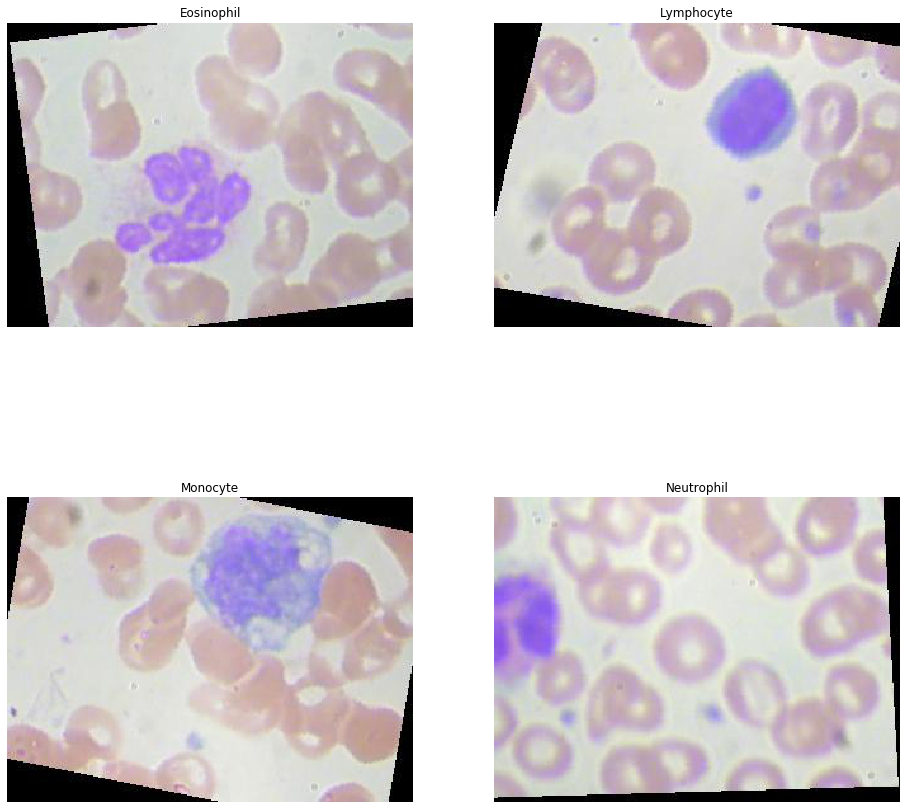

In [4]:
# Plot Image
def plotImage(image_location):
    image = np.asarray(Image.open(image_name))
    print(type(image))
    plt.imshow(image)
    return
image_name = 'input/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL/_0_207.jpeg'
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.title('Eosinophil')
plt.axis('off') 
plotImage(image_name)
image_name = 'input/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_0_204.jpeg'
plt.subplot(222)
plt.title('Lymphocyte')
plt.axis('off') 
plotImage(image_name)
image_name = 'input/dataset2-master/dataset2-master/images/TRAIN/MONOCYTE/_0_375.jpeg'
plt.subplot(223)
plt.title('Monocyte')
plt.axis('off') 
plotImage(image_name)
plt.subplot(224)
image_name = 'input/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL/_0_292.jpeg'
plt.title('Neutrophil')
plt.axis('off') 
plotImage(image_name)

[  3  88  33  21 207]


Text(0, 0.5, 'Counts')

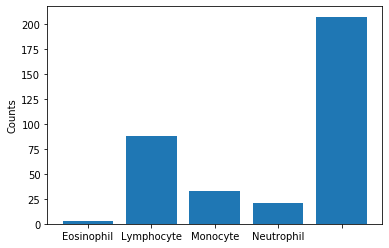

In [5]:
reader = csv.reader(open('input/dataset2-master/dataset2-master/labels.csv'))
# skip the header
next(reader)
X3 = []
y3 = []
for row in reader:
    label = row[2]
    if len(label) > 0 and label.find(',') == -1:
        y3.append(label)
y3 = np.asarray(y3)
encoder = LabelEncoder()
encoder.fit(y3)
encoded_y = encoder.transform(y3)
counts = np.bincount(encoded_y)
print(counts)
fig, ax = plt.subplots()
plt.bar(list(range(5)), counts)
ax.set_xticklabels(('', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil'))
ax.set_ylabel('Counts')

In [6]:
from tqdm import tqdm
def get_data(folder):
    X = []
    y = []
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 1
            elif wbc_type in ['EOSINOPHIL']:
                label = 2
            elif wbc_type in ['MONOCYTE']:
                label = 3  
            elif wbc_type in ['LYMPHOCYTE']:
                label = 4 
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = np.asarray(Image.open(folder + wbc_type + '/' + image_filename))
                if img_file is not None:
                    img_arr = np.asarray(Image.fromarray(img_file).resize((60, 80)))
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y
X_train, y_train = get_data('input/dataset2-master/dataset2-master/images/TRAIN/')
X_test, y_test = get_data('input/dataset2-master/dataset2-master/images/TEST/')

y_train_oh = to_categorical(y_train, num_classes = 5)
y_test_oh = to_categorical(y_test, num_classes = 5)
print(dict_characters)

100%|███████████████████████████████████████████████████████████████████████████████| 624/624 [00:02<00:00, 212.82it/s]

{1: 'NEUTROPHIL', 2: 'EOSINOPHIL', 3: 'MONOCYTE', 4: 'LYMPHOCYTE'}


{1: 'NEUTROPHIL', 2: 'EOSINOPHIL', 3: 'MONOCYTE', 4: 'LYMPHOCYTE'}


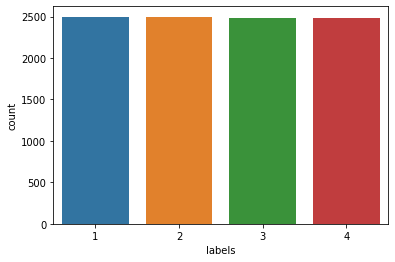

In [7]:
import seaborn as sns
df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

In [8]:
X_train=np.array(X_train)
X_train=X_train/255.0

X_test=np.array(X_test)
X_test=X_test/255.0

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')

def plot_learning_curve(history):
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('accuracy_curve.png')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('loss_curve.png')

In [10]:
batch_size = 32
epochs = 100

num_classes = len(y_train_oh[0])

img_rows,img_cols=80,60
input_shape = (img_rows, img_cols, 3)


model = Sequential()
model.add(Conv2D(32, (3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy'])

history = model.fit(X_train, y_train_oh, batch_size=batch_size,
                    epochs=epochs, validation_data = (X_test, y_test_oh))
score = model.evaluate(X_test, y_test_oh, verbose=0)

Epoch 1/100
312/312 [==============================] - 7s 22ms/step - loss: 1.4795 - accuracy: 0.2483 - val_loss: 1.3890 - val_accuracy: 0.2485
Epoch 2/100
312/312 [==============================] - 7s 21ms/step - loss: 1.4006 - accuracy: 0.2497 - val_loss: 1.3671 - val_accuracy: 0.3904
Epoch 3/100
312/312 [==============================] - 7s 21ms/step - loss: 1.3265 - accuracy: 0.3466 - val_loss: 1.1735 - val_accuracy: 0.4443
Epoch 4/100
312/312 [==============================] - 7s 21ms/step - loss: 1.2083 - accuracy: 0.4323 - val_loss: 1.0683 - val_accuracy: 0.4901
Epoch 5/100
312/312 [==============================] - 7s 21ms/step - loss: 1.1192 - accuracy: 0.4772 - val_loss: 0.9975 - val_accuracy: 0.4990
Epoch 6/100
312/312 [==============================] - 7s 21ms/step - loss: 1.0836 - accuracy: 0.4974 - val_loss: 1.0159 - val_accuracy: 0.4853
Epoch 7/100
312/312 [==============================] - 7s 21ms/step - loss: 1.0401 - accuracy: 0.5178 - val_loss: 0.9885 - val_accuracy:

312/312 [==============================] - 7s 21ms/step - loss: 0.0688 - accuracy: 0.9726 - val_loss: 0.9668 - val_accuracy: 0.7986
Epoch 58/100
312/312 [==============================] - 7s 21ms/step - loss: 0.1206 - accuracy: 0.9567 - val_loss: 1.0696 - val_accuracy: 0.8006
Epoch 59/100
312/312 [==============================] - 7s 21ms/step - loss: 0.0548 - accuracy: 0.9802 - val_loss: 1.2317 - val_accuracy: 0.8134
Epoch 60/100
312/312 [==============================] - 7s 21ms/step - loss: 0.0705 - accuracy: 0.9736 - val_loss: 1.3784 - val_accuracy: 0.7994
Epoch 61/100
312/312 [==============================] - 7s 21ms/step - loss: 0.1449 - accuracy: 0.9504 - val_loss: 1.1526 - val_accuracy: 0.7821
Epoch 62/100
312/312 [==============================] - 7s 21ms/step - loss: 0.0670 - accuracy: 0.9756 - val_loss: 1.2931 - val_accuracy: 0.7813
Epoch 63/100
312/312 [==============================] - 7s 21ms/step - loss: 0.0826 - accuracy: 0.9718 - val_loss: 1.2582 - val_accuracy: 0.795

In [11]:
import tensorflow as tf
tf.keras.utils.plot_model(model)

InvocationException: GraphViz's executables not found


Accuracy: 0.8049859404563904 


              precision    recall  f1-score   support

  NEUTROPHIL       0.64      0.77      0.70       624
  EOSINOPHIL       0.72      0.74      0.73       623
    MONOCYTE       0.96      0.76      0.85       620
  LYMPHOCYTE       0.97      0.95      0.96       620

    accuracy                           0.80      2487
   macro avg       0.82      0.81      0.81      2487
weighted avg       0.82      0.80      0.81      2487



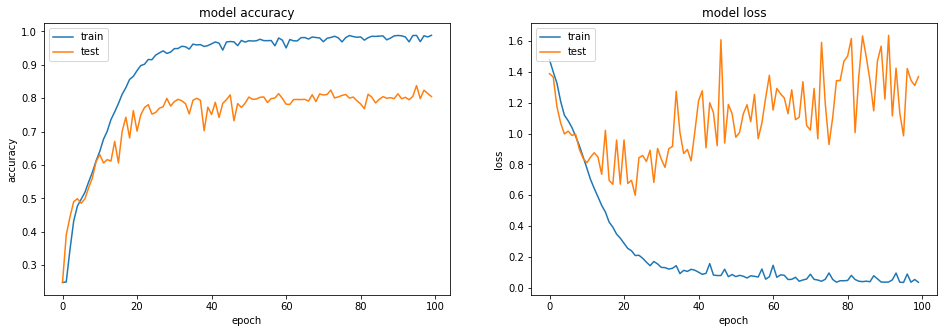

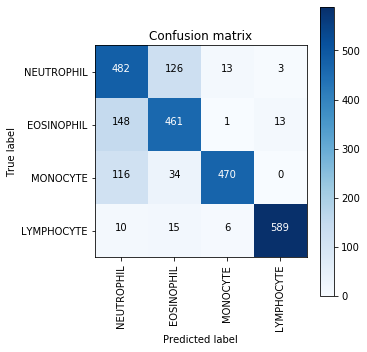

In [12]:
print('\nAccuracy:', score[1],'\n')
y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(y_test_oh,axis=1)

print('\n', classification_report(Y_true, Y_pred_classes, target_names=list(dict_characters.values())), sep='')    

plot_learning_curve(history)
plt.show()
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
plt.show()


In [14]:
model.save('modelo')

W0827 21:19:50.453367  3728 deprecation.py:506] From C:\Users\heito\anaconda3\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
